<a href="https://colab.research.google.com/github/Lisker2/CS309_Project/blob/main/Protein_Enhancer_shuffled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nadavbra/shared_utils.git
!git clone https://github.com/nadavbra/protein_bert
!git clone https://github.com/khanhlee/bert-enhancer
!pip install protein-bert

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
from proteinbert import load_pretrained_model
pretrained_model_generator, input_encoder = load_pretrained_model("/content/")

 Local model dump file /content/default.pkl doesn't exist. Will download ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/epoch_92400_sample_23500000.pkl into /content/. Please approve or reject this (to exit and potentially call the function again with different parameters).
Do you approve downloadig the file into the specified directory? Please specify "Yes" or "No":yes
Downloaded file: /content/epoch_92400_sample_23500000.pkl
Created: /content/default.pkl


In [ ]:
# read the orginal data
non_cv = pd.read_csv('bert-enhancer/data/non.cv.txt')[::2]
non_cv.columns = ['seq']

label_1 = [0 for i in range(len(non_cv))]
non_cv['label'] = label_1

enhancer_cv = pd.read_csv('bert-enhancer/data/enhancer.cv.txt')[::2]
enhancer_cv.columns = ['seq']

label_1 = [1 for i in range(len(enhancer_cv))]
enhancer_cv['label'] = label_1

non_ind = pd.read_csv('bert-enhancer/data/non.ind.txt')[::2]
non_ind.columns = ['seq']

label_1 = [0 for i in range(len(non_ind))]
non_ind['label'] = label_1

enhancer_ind = pd.read_csv('bert-enhancer/data/enhancer.ind.txt')[::2]
enhancer_ind.columns = ['seq']

label_1 = [1 for i in range(len(enhancer_ind))]
enhancer_ind['label'] = label_1

# concat data with label 1 and 0 seperately -- shuffled
enhancer_total = pd.concat([enhancer_cv, enhancer_ind],axis=0).sample(frac=1.0).reset_index(drop=True)
non_total = pd.concat([non_cv, non_ind ],axis=0).sample(frac=1.0).reset_index(drop=True)

# 1684 in total train = 1384 valid = 150 test = 150
train = pd.concat([enhancer_total[:1384], non_total[:1384]],axis=0).sample(frac=1.0).reset_index(drop=True)
valid = pd.concat([enhancer_total[1384:1534], non_total[1384:1534]],axis=0).sample(frac=1.0).reset_index(drop=True)
test = pd.concat([enhancer_total[1534:], non_total[1534:]],axis=0).sample(frac=1.0).reset_index(drop=True)

# max len
enhancer_sequence_length = train['seq'].map(lambda x: len(x)).max() + 2
print('sequence_length', enhancer_sequence_length)

# get the model
enhancer_model_generator = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(enhancer_sequence_length))

# get outputs
enhancer_train_X = input_encoder.encode_X(train['seq'], enhancer_sequence_length)
enhancer_valid_X = input_encoder.encode_X(valid['seq'], enhancer_sequence_length)
enhancer_test_X = input_encoder.encode_X(test['seq'], enhancer_sequence_length)
enhancer_local_representations_train, global_representations_train = enhancer_model_generator.predict(enhancer_train_X, batch_size = 64)
enhancer_local_representations_valid, global_representations_valid = enhancer_model_generator.predict(enhancer_valid_X, batch_size = 64)
enhancer_local_representations_test, global_representations_test = enhancer_model_generator.predict(enhancer_test_X, batch_size = 64)

sequence_length 202


5/5 [==============================] - 12s 2s/step


In [ ]:
model_enhancer = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = enhancer_local_representations_train[0].shape),
    tf.keras.layers.Dense(3, activation = 'linear'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
model_enhancer.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-10, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

history_stability = model_enhancer.fit(enhancer_local_representations_train, train['label'], 
                                               validation_data=(enhancer_local_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

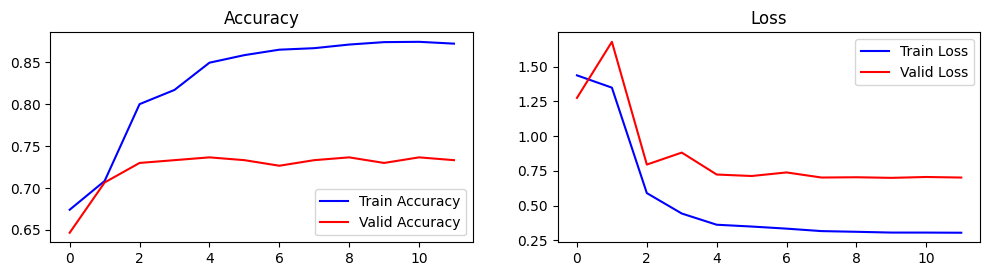

In [ ]:
accuracy = history_stability.history['accuracy']
val_accuracy = history_stability.history['val_accuracy']
loss = history_stability.history['loss']
val_loss = history_stability.history['val_loss']

epoch = range(len(accuracy))

plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.plot(epoch, accuracy, 'b', label='Train Accuracy')
plt.plot(epoch, val_accuracy, 'r', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()


plt.subplot(2,2,2)
plt.plot(epoch, loss, 'b', label='Train Loss')
plt.plot(epoch, val_loss, 'r', label='Valid Loss')
plt.title('Loss')
plt.legend()

In [ ]:
enhancer_predict_Y = model_enhancer.predict(enhancer_local_representations_test)
label = []
for i in enhancer_predict_Y:
  if i[0] <= 0.5:
    label.append(0)
  else:
    label.append(1)
correct = 0
for i in range(len(label)):
  if label[i] == test['label'][i]:
    correct += 1
correct / len(label)

10/10 [==============================] - 1s 38ms/step


0.7133333333333334

In [ ]:
model_enhancer = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(202, 1562, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
model_enhancer.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-10, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

history_stability = model_enhancer.fit(enhancer_local_representations_train, train['label'], 
                                               validation_data=(enhancer_local_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

Epoch 1/40
87/87 [==============================] - 396s 5s/step - loss: 1.7189 - accuracy: 0.6774 - val_loss: 0.4765 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 2/40
87/87 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.7612
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
87/87 [==============================] - 386s 4s/step - loss: 0.4909 - accuracy: 0.7612 - val_loss: 0.4908 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 3/40
87/87 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8374
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
87/87 [==============================] - 381s 4s/step - loss: 0.3826 - accuracy: 0.8374 - val_loss: 0.5000 - val_accuracy: 0.7467 - lr: 2.5000e-04


In [ ]:
enhancer_predict_Y = model_enhancer.predict(enhancer_local_representations_test)
label = []
for i in enhancer_predict_Y:
  if i[0] <= 0.5:
    label.append(0)
  else:
    label.append(1)
correct = 0
for i in range(len(label)):
  if label[i] == test['label'][i]:
    correct += 1
correct / len(label)

10/10 [==============================] - 17s 2s/step


0.73

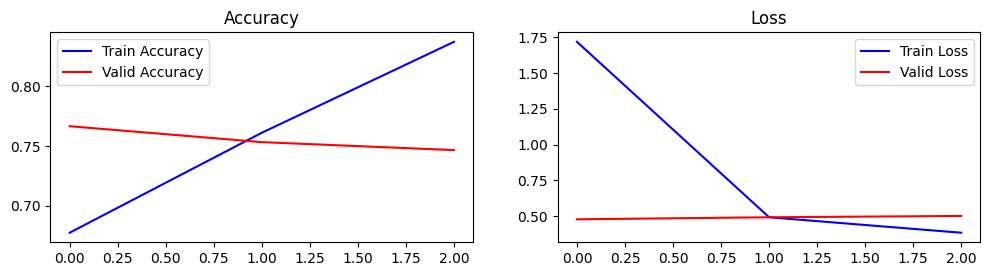

In [ ]:
accuracy = history_stability.history['accuracy']
val_accuracy = history_stability.history['val_accuracy']
loss = history_stability.history['loss']
val_loss = history_stability.history['val_loss']

epoch = range(len(accuracy))

plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.plot(epoch, accuracy, 'b', label='Train Accuracy')
plt.plot(epoch, val_accuracy, 'r', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()


plt.subplot(2,2,2)
plt.plot(epoch, loss, 'b', label='Train Loss')
plt.plot(epoch, val_loss, 'r', label='Valid Loss')
plt.title('Loss')
plt.legend()